# Package

In [2]:
# pip install statsmodels


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from statsmodels.tsa.stattools import acf


# Load data

In [4]:
def load_data():
    df = pd.read_csv('../data/kzhan176/citizens_data/BrownDSI_masked_capstone_data.csv_20250401031515')
    return df

In [5]:
df = load_data()
df.head()

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
0,0,0,0,0,0,5000+,1,517.81,517.81,2024-08-01,...,1882.21,4.0,470.5525,535.92,400.77,NaN,NaN,0,0,8
1,2,0,0,2,1,0-1000,1,150.00,150.00,2024-04-25,...,150.00,1.0,150.0000,150.00,150.00,NaN,NaN,0,0,4
2,3,0,0,3,0,5000+,0,2603.24,2451.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,3
3,4,0,0,4,1,5000+,0,770.00,770.00,2024-11-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,11
4,7,0,0,7,1,2000-5000,2,10776.63,145.00,2024-05-29,...,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,NaN,0,0,5


In [ ]:
# GOAL 预测当前这笔存款（item_amt）最终是否会被return（退票）
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   masked_dep_acct_num       17765 non-null  int64  
 1   masked_bank_num           17765 non-null  int64  
 2   masked_account_type       17765 non-null  int64  
 3   masked_id                 17765 non-null  int64  
 4   masked_product_code       17765 non-null  int64  
 5   bucket_days_since_open    17738 non-null  object 
 6   number_of_owners          17765 non-null  int64  
 7   total_deposit_amount      17765 non-null  float64
 8   item_amt                  17765 non-null  float64
 9   deposit_dt                17765 non-null  object 
 10  channel                   17765 non-null  object 
 11  relationship_balance      17765 non-null  int64  
 12  oao_flg                   17765 non-null  object 
 13  onus_ind                  17765 non-null  object 
 14  treasu

# First pipeline - raw data and added features

A pipeline using the combination of raw data and newly added features, evaluated with XGBoost

- Use raw data + new features with only minimal cleaning (no scaling, no clipping, no missing value imputation) and let XGBoost handle the data directly.

In [10]:
df.query('relationship_balance == 0').head(4)

,masked_dep_acct_num,masked_bank_num,masked_account_type,masked_id,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,deposit_dt,...,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,RETURN_REASON,return_target,over_draft_amount,month_num
2421,5485,0,0,6149,1,0-1000,1,281.00,281.00,2024-08-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8
3566,8034,0,0,9252,1,0-1000,0,537.00,537.00,2024-03-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,15,3
7054,15306,0,1,18674,2,0-1000,2,11117.79,11117.79,2024-08-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8
7244,15700,0,0,19191,1,0-1000,1,12000.00,12000.00,2024-08-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,8


In [ ]:
def xgboost_fe(df):
    """
    XGBoost Feature Engineering Minimal Cleaning Pipeline

    - Drop specified irrelevant columns
    - Convert deposit_dt to datetime and extract quarter and week (prefix 'fe_')
    - Drop original deposit_dt after extraction
    - No scaling of continuous features
    - No one-hot encoding
    - No missing value imputation
    - No clipping of extreme values
    """

    
    # --------------- Drop columns --------------- 
    cols_to_drop = [
        'masked_dep_acct_num',
        'masked_id',
        'channel',
        'RDI_DT',
        'RETURN_REASON',
        'over_draft_amount',
    ]
    df = df.drop(columns=cols_to_drop, errors='ignore')

    # --------------- process deposit_dt columns --------------- 
    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'], errors='coerce')
    df['fe_deposit_quarter'] = df['deposit_dt'].dt.quarter
    df['fe_deposit_week'] = df['deposit_dt'].dt.isocalendar().week
    df = df.drop(columns=['deposit_dt'])


    # --------------- process item_amt, total_deposit_amount, relationship_balance columns --------------- 
    ## Ratio of current deposit item amount to total deposit amount, large single deposits are potentially unusual 如果一笔交易占今天总交易很大一部分会不会是诈骗
    df['fe_amt_ratio_to_total'] = df['item_amt'] / (df['total_deposit_amount'] + 1)
    ## Ratio of current deposit item amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果一笔交易占用户总余额很大一部分会不会是诈骗
    df['fe_amt_ratio_to_balance'] = df['item_amt'] / (df['relationship_balance'] + 1)
    ## Ratio of total deposit amount to prior day's total balance, Some frauds are small balance with large deposits all of a sudden. 如果今天的总交易占用户总余额很大一部分会不会是诈骗
    df['fe_total_amt_ratio_to_balance'] = df['total_deposit_amount'] / (df['relationship_balance'] + 1)
    ## Difference between current deposit amount and previous transaction amount, abnormal fluctuations 如果这笔交易比上一笔变化很多会不会是诈骗
    df['fe_amt_change_from_prev'] = df['item_amt'] - df['prevtran1']
    ## Flag indicating whether the current deposit item is 1.5x larger than the past 30-day maximum deposit, Is it significantly higher than the largest deposit in the last 30 days 如果一笔交易是这一个月的最大交易会不会是诈骗
    df['fe_high_amt_flag'] = (df['item_amt'] > (df['max_deposit_amount30d'] * 1.5)).astype(int)
    ## Ratio of maximum single deposit amount in past 30 days to the total deposit amount 
    df['fe_max30d_ratio_total'] = df['max_deposit_amount30d'] / (df['total_deposit_amount'] + 1)

    # --------------- process rdis columns --------------- 
    ## fill NA as 0 to rdis
    df['rdis'] = df['rdis'].fillna(0)
    df['fe_rdis_flag'] = (df['rdis'] > 0).astype(int)

    # --------------- process prevtrandate columns --------------- 
    ## process prevtrandate to capture short-term transaction frequency.
    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    # Create transaction count features
    ## Number of transactions within 1 day
    df['fe_num_trans_in_1d'] = (df[prevtrandate_cols] <= 1).sum(axis=1)
    ## Number of transactions within 5 days
    df['fe_num_trans_in_5d'] = (df[prevtrandate_cols] <= 5).sum(axis=1)
    ## Number of transactions within 10 days
    df['fe_num_trans_in_10d'] = (df[prevtrandate_cols] <= 10).sum(axis=1)
    ## Average days between previous transactions
    df['fe_avg_prevtrandate'] = df[prevtrandate_cols].mean(axis=1)
    ## Standard deviation of days between previous transactions
    df['fe_std_prevtrandate'] = df[prevtrandate_cols].std(axis=1)
    ## Rolling mean of the most recent 3 and 5 previous transaction days
    df['fe_rolling_mean_prevtrandate_3'] = df[prevtrandate_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtrandate_5'] = df[prevtrandate_cols[:5]].mean(axis=1)
    ## Rolling standard deviation of the most recent 3 and 5 previous transaction days
    df['fe_rolling_std_prevtrandate_3'] = df[prevtrandate_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtrandate_5'] = df[prevtrandate_cols[:5]].std(axis=1)


    # ------------ process prevtran columns ------------
    # volatility of item_amt compared to historical transaction amounts
    ## Mean of previous 10 deposits  ps If there is all NaN, the result of std is NaN!
    df['fe_avg_prevtran_amt'] = df[prevtran_cols].mean(axis=1)
    ## Standard deviation of previous 10 deposits ps If there is only 1 valid number or all NaN, the result of std is NaN!
    df['fe_std_prevtran_amt'] = df[prevtran_cols].std(axis=1)
    ## Maximum amount among previous 10 deposits ps If there is all NaN, the result of std is NaN!
    df['fe_max_prevtran_amt'] = df[prevtran_cols].max(axis=1)
    ## Current deposit amount compared to historical average 
    df['fe_amt_current_vs_avg'] = df['item_amt'] / (df['fe_avg_prevtran_amt'] + 1)
    ## Current deposit amount compared to historical maximum 
    df['fe_amt_current_vs_max'] = df['item_amt'] / (df['fe_max_prevtran_amt'] + 1)
    # Rolling part to capture short-term behavioral trends from the latest 3 or 5 transactions.
    # Rolling mean of the most recent 3 and 5 previous transactions ps If there is all NaN, the result of std is NaN!
    df['fe_rolling_mean_prevtran_3'] = df[prevtran_cols[:3]].mean(axis=1)
    df['fe_rolling_mean_prevtran_5'] = df[prevtran_cols[:5]].mean(axis=1)
    # Rolling standard deviation of the most recent 3 and 5 previous transactions ps if If there is only 1 valid number or all NaN, the result is NaN!
    df['fe_rolling_std_prevtran_3'] = df[prevtran_cols[:3]].std(axis=1)
    df['fe_rolling_std_prevtran_5'] = df[prevtran_cols[:5]].std(axis=1)
    ## Create a feature indicating whether the current deposit is the first known deposit
    df['fe_is_first_deposit'] = df[prevtran_cols].isna().all(axis=1).astype(int)

    # Step 4: Copy to new DataFrame
    df_for_xgboost = df.copy()

    return df_for_xgboost


In [18]:
pd.set_option('display.max_columns', None)

df_xgboost = xgboost_fe(df)
df_xgboost.head()

,masked_bank_num,masked_account_type,masked_product_code,bucket_days_since_open,number_of_owners,total_deposit_amount,item_amt,relationship_balance,oao_flg,onus_ind,treasury_check_ind,heloc_ind,rdis,max_deposit_amount30d,total_deposit_item_count,prevtran1,prevtran2,prevtran3,prevtran4,prevtran5,prevtran6,prevtran7,prevtran8,prevtran9,prevtran10,prevtrandate1,prevtrandate2,prevtrandate3,prevtrandate4,prevtrandate5,prevtrandate6,prevtrandate7,prevtrandate8,prevtrandate9,prevtrandate10,drawee_sum,drawee_cnt,drawee_avg,drawee_max,drawee_min,RDI_DT,return_target,month_num,fe_deposit_quarter,fe_deposit_week,fe_amt_ratio_to_total,fe_amt_ratio_to_balance,fe_total_amt_ratio_to_balance,fe_amt_change_from_prev,fe_high_amt_flag,fe_max30d_ratio_total,fe_rdis_flag,fe_num_trans_in_1d,fe_num_trans_in_5d,fe_num_trans_in_10d,fe_avg_prevtrandate,fe_std_prevtrandate,fe_rolling_mean_prevtrandate_3,fe_rolling_mean_prevtrandate_5,fe_rolling_std_prevtrandate_3,fe_rolling_std_prevtrandate_5,fe_avg_prevtran_amt,fe_std_prevtran_amt,fe_max_prevtran_amt,fe_amt_current_vs_avg,fe_amt_current_vs_max,fe_rolling_mean_prevtran_3,fe_rolling_mean_prevtran_5,fe_rolling_std_prevtran_3,fe_rolling_std_prevtran_5,fe_is_first_deposit
0,0,0,0,5000+,1,517.81,517.81,160872,N,F,N,N,0.0,994.77,1,452.76,464.01,426.27,497.32,356.26,517.25,475.0,425.62,425.62,548.79,9.0,9.0,20.0,30.0,30.0,37.0,44.0,52.0,52.0,58.0,1882.21,4.0,470.5525,535.92,400.77,NaN,0,8,3,31,0.998073,0.003219,0.003219,65.05,0,1.917407,0,0,0,2,34.1,17.672640,12.666667,19.6,6.350853,10.502381,458.890000,54.872433,548.79,1.125943,0.941832,447.68,439.324,19.376060,52.970501,0
1,0,0,1,0-1000,1,150.00,150.00,485,N,F,N,N,0.0,60.00,1,200.00,200.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.00,1.0,150.0000,150.00,150.00,NaN,0,4,2,17,0.993377,0.308642,0.308642,-50.00,1,0.397351,0,0,0,0,68.0,4.242641,68.000000,68.0,4.242641,4.242641,200.000000,0.000000,200.00,0.746269,0.746269,200.00,200.000,0.000000,0.000000,0
2,0,0,0,5000+,0,2603.24,2451.00,27059,N,F,N,N,88.0,0.00,2,152.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,1,12,0.941157,0.090576,0.096203,2298.76,1,0.000000,1,1,1,1,0.0,NaN,0.000000,0.0,NaN,NaN,152.240000,NaN,152.24,15.994518,15.994518,152.24,152.240,NaN,NaN,0
3,0,0,1,5000+,0,770.00,770.00,2107,N,F,N,N,0.0,7000.00,1,9214.80,1310.72,2200.00,2400.00,2400.00,2400.00,7000.0,NaN,NaN,NaN,87.0,123.0,162.0,172.0,172.0,172.0,253.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,11,4,48,0.998703,0.365275,0.365275,-8444.80,0,9.079118,0,0,0,0,163.0,51.185936,124.000000,143.2,37.509999,37.345682,3846.502857,3005.035672,9214.80,0.200130,0.083552,4241.84,3505.104,4329.601956,3223.420377,0
4,0,0,1,2000-5000,2,10776.63,145.00,4916,N,F,N,N,0.0,5953.38,5,750.00,2000.00,310.00,175.00,500.00,1000.00,3000.0,525.00,268.38,225.00,16.0,16.0,16.0,16.0,20.0,20.0,20.0,20.0,20.0,20.0,7860.00,1.0,7860.0000,7860.00,7860.00,NaN,0,5,2,22,0.013454,0.029490,2.191708,-605.00,0,0.552383,0,0,0,0,18.4,2.065591,16.000000,16.8,0.000000,1.788854,875.338000,923.479933,3000.00,0.165461,0.048317,1020.00,747.000,876.755382,733.004093,0


In [19]:
df_xgboost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 71 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   masked_bank_num                 17765 non-null  int64  
 1   masked_account_type             17765 non-null  int64  
 2   masked_product_code             17765 non-null  int64  
 3   bucket_days_since_open          17738 non-null  object 
 4   number_of_owners                17765 non-null  int64  
 5   total_deposit_amount            17765 non-null  float64
 6   item_amt                        17765 non-null  float64
 7   relationship_balance            17765 non-null  int64  
 8   oao_flg                         17765 non-null  object 
 9   onus_ind                        17765 non-null  object 
 10  treasury_check_ind              17765 non-null  object 
 11  heloc_ind                       17765 non-null  object 
 12  rdis                            

# 之前写的⬇️

In [ ]:
def process_calgorial_features(df):

    '''
    one hot encoding:
    - masked_bank_num
    - masked_account_type
    - masked_product_code_grouped
    - relationship_balance_new_account
    - oao_flg
    - onus_ind
    - treasury_check_ind
    - heloc_ind
    '''

    # drop unused columns
    cols_to_drop = ['masked_dep_acct_num', 'masked_id', 'channel', 'drawee_avg', 'drawee_max', 'drawee_min', 'RDI_DT', 'RETURN_REASON', 'over_draft_amount']
    df.drop(columns=cols_to_drop, inplace=True)

    # process masked_product_code
    top_n = 8
    top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index
    df['masked_product_code_grouped'] = df['masked_product_code'].apply(
        lambda x: f'prod_{x}' if x in top_product_codes else 'Other'
    )
    df.drop(columns='masked_product_code', inplace=True)

    # one_hot_features = ['masked_bank_num', 'masked_account_type', 'masked_product_code_grouped']
    # df = pd.get_dummies(df, columns=one_hot_features)
    
    df['oao_flg'] = (df['oao_flg'] == 'Y').astype(int)


    '''
    ordinal encoding
    - bucket_days_since_open
    - deposit_quarter
    - deposit_dayofweek
    '''

    # fill missing values with -1
    df['bucket_days_since_open'] = df['bucket_days_since_open'].fillna(-1)
    ordinal_mapping = {
    '0-1000': 0,
    '1000-2000': 1,
    '2000-5000': 2,
    '5000+': 3,
    -1: -1   
    }
    
    df['bucket_days_since_open'] = df['bucket_days_since_open'].map(ordinal_mapping)
    print(df['bucket_days_since_open'].unique())

    df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])
    df['deposit_quarter'] = df['deposit_dt'].dt.quarter.astype(str)  # convert to str for one-hot
    df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek.astype(str)  # convert to str for one-hot
    df.drop(columns='deposit_dt', inplace=True)

    cat_ftrs = ['onus_ind', 'treasury_check_ind', 'heloc_ind',
            'masked_bank_num', 'masked_account_type', 'masked_product_code_grouped', 'relationship_balance_new_account', 'oao_flg', 'deposit_dayofweek', 'deposit_quarter']

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='other')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])


    return categorical_transformer, cat_ftrs


def process_continous_features(df):
    # total_deposit_amount
    df['total_deposit_amount'] = df['total_deposit_amount'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # item_amt
    df['item_amt'] = df['item_amt'].apply(lambda x: np.log1p(x) if x > 0 else 0)

    # relationship_balance
    df['relationship_balance_new_account'] = (df['relationship_balance'] == -99999999).astype(int)
    df['relationship_balance'] = df['relationship_balance'].replace(-99999999, np.nan)
    median_val = df['relationship_balance'].median()
    df['relationship_balance'] = df['relationship_balance'].fillna(median_val)
    min_val = df['relationship_balance'].min()
    shift = 1 - min_val if min_val <= 0 else 0
    df['relationship_balance'] = np.log1p(df['relationship_balance'] + shift)

    # rdis, max_deposit_amount30d, total_deposit_item_count
    # drawee_sum, drawee_cnt
    num_ftrs = ['drawee_sum', 'drawee_cnt']
    log_num_ftrs = ['rdis', 'max_deposit_amount30d', 'total_deposit_item_count']

    df['rdis'] = df['rdis'].fillna(0)
    df['drawee_sum'] = df['drawee_sum'].fillna(0)
    df['drawee_cnt'] = df['drawee_cnt'].fillna(0)

    numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

    log_numeric_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p, feature_names_out = 'one-to-one')),
        ('scaler', RobustScaler())])
    
    return log_numeric_transformer, log_num_ftrs, numeric_transformer, num_ftrs

'''
helper function for process_prevtran_features
'''
def prevtran_missing_imputation(df, flag="zero"):
    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    if flag == "zero":
        imputer = SimpleImputer(strategy='constant', fill_value=0)
        df[prevtran_cols] = imputer.fit_transform(df[prevtran_cols])
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'zero' is supported.")

'''
helper function for process_prevtran_features
'''
def prevtrandate_missing_imputation(df, flag="prevdate"):

    if flag == "prevdate":
        def impute_prevtrandate(row):
            # Find the last available value (starting from 10 to 1)
            for i in reversed(range(10)):
                val = row[prevtrandate_cols[i]]
                if not pd.isna(val):
                    return row.fillna(val)
            return row.fillna(0)

        prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
        df[prevtrandate_cols] = df[prevtrandate_cols].apply(impute_prevtrandate, axis=1)
    else:
        raise ValueError(f"Invalid flag: {flag}. Only 'prevdate' is supported.")

'''
Helper function for process_prevtran_features
'''
from statsmodels.tsa.stattools import acf

def compute_acf_lag1(row):
    x = row.values.astype(float)
    return pd.Series([acf(x, nlags=1, fft=False)[1]])

'''
deal with prevtran* and prevtrandate*
'''
def process_prevtran_features(df):

    prevtran_cols = [f'prevtran{i}' for i in range(1, 11)]
    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]  # keep prevtran1–6
    drop_prevtran_cols = [f'prevtran{i}' for i in range(7, 11)]

    prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 11)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]  # keep prevtrandate1–3
    drop_prevtrandate_cols = [f'prevtrandate{i}' for i in range(4, 11)]

    # Mean, median, std, min, max, and sum across previous transactions, 
    # preserve absence of behavior in the statistics by computing before imputing
    df['prevtran_mean'] = df[prevtran_cols].mean(axis=1, skipna=True)
    df['prevtran_std'] = df[prevtran_cols].std(axis=1, skipna=True)
    df['prevtran_sum'] = df[prevtran_cols].sum(axis=1, skipna=True)
    df['prevtran_valid_count'] = df[prevtran_cols].notnull().sum(axis=1)

    # prevtrandate summary stats
    df['prevtrandate_mean'] = df[prevtrandate_cols].mean(axis=1, skipna=True)
    df['prevtrandate_std'] = df[prevtrandate_cols].std(axis=1, skipna=True)

    # add an isoutlier column to preserve extreme behavior as a signal
    threshold = df[prevtran_cols].stack().quantile(0.99)
    df['isoutlier_prevtran'] = (df[prevtran_cols].max(axis=1) > threshold).astype(int)

    # impute missing values
    prevtran_missing_imputation(df)
    prevtrandate_missing_imputation(df)
    # if not check_prevtran_imputed:
    #     raise ValueError(f"Imputation incomplete: Some prevtran/prevtrandate values are still missing.")

    # take log of prevtran1–6, since data right-skewed
    df[keep_prevtran_cols] = df[keep_prevtran_cols].applymap(lambda x: np.log1p(x) if x > 0 else 0)

    # prevtran_diff0, prevtran_ratio0
    df['prevtran_diff0'] = df['total_deposit_amount'] - df['prevtran1']
    df['prevtran_ratio0'] = df['total_deposit_amount'] / (df['prevtran1'] + 1e-3)
    
    # prevtran_diff1, prevtran_ratio1
    df['prevtran_diff1'] = df['prevtran1'] - df['prevtran2']
    df['prevtran_ratio1'] = df['prevtran1'] / (df['prevtran2'] + 1e-3)
    
    # timeseries features: acf
    df[['acf_lag1']] = df[keep_prevtran_cols].apply(compute_acf_lag1, axis=1)

    # rolling window features
    # TODO
    
    # drop columns
    columns_to_drop = (drop_prevtran_cols + drop_prevtrandate_cols)
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


def normalization(df):
    robust_scaler = RobustScaler()
    standard_scaler = StandardScaler()

    keep_prevtran_cols = [f'prevtran{i}' for i in range(1, 7)]
    keep_prevtrandate_cols = [f'prevtrandate{i}' for i in range(1, 4)]

    robust_scalar_features = ['total_deposit_amount', 'item_amt'] + keep_prevtran_cols + \
                        ['prevtran_mean', 'prevtran_std', 'prevtran_sum', 'prevtran_diff0', 'prevtran_ratio0'] + \
                        ['prevtran_diff1', 'prevtran_ratio1', 'acf_lag1']
    standard_scaler_features = keep_prevtrandate_cols + ['relationship_balance', 'drawee_sum', 'drawee_cnt',
   'rdis', 'max_deposit_amount30d', 'total_deposit_item_count'] + ['prevtrandate_mean', 'prevtrandate_std']
    
    return robust_scaler, robust_scalar_features, standard_scaler, standard_scaler_features


def feature_engineer(df):

    categorical_transformer, cat_ftrs = process_calgorial_features(df)
    log_numeric_transformer, log_num_ftrs, numeric_transformer, num_ftrs = process_continous_features(df)
    process_prevtran_features(df)
    robust_scaler, robust_scalar_features, standard_scaler, standard_scaler_features = normalization(df)
    
    preprocessor = ColumnTransformer(
        transformers=[
            # From categorical_transformer
            ('cat', categorical_transformer, cat_ftrs),

            # From continous_transformer (log and standard scaled)
            ('log_num', log_numeric_transformer, log_num_ftrs),
            ('num', numeric_transformer, num_ftrs),

            # From normalizer
            ('robust_scaler', robust_scaler, robust_scalar_features),
            ('standard_scaler', standard_scaler, standard_scaler_features)
        ],
        remainder='passthrough')
    X_transformed = preprocessor.fit_transform(df)
    feature_names = preprocessor.get_feature_names_out()
    df_final = pd.DataFrame(X_transformed, columns=feature_names, index=df.index)
    
    return X_transformed, df_final

# Check

In [7]:
df = load_data()
top_n = 8
top_product_codes = df['masked_product_code'].value_counts().nlargest(top_n).index
print(top_product_codes)

Index([1, 0, 2, 4, 5, 6, 7, 9], dtype='int64', name='masked_product_code')


In [8]:
df_final['remainder__bucket_days_since_open'].value_counts()

remainder__bucket_days_since_open
 3.0    8411
 2.0    3949
 0.0    3674
 1.0    1704
-1.0      27
Name: count, dtype: int64

In [9]:
df_final['remainder__number_of_owners'].value_counts()

remainder__number_of_owners
1.0    8713
2.0    6411
0.0    1972
3.0     557
4.0      97
5.0       8
6.0       3
8.0       2
7.0       2
Name: count, dtype: int64

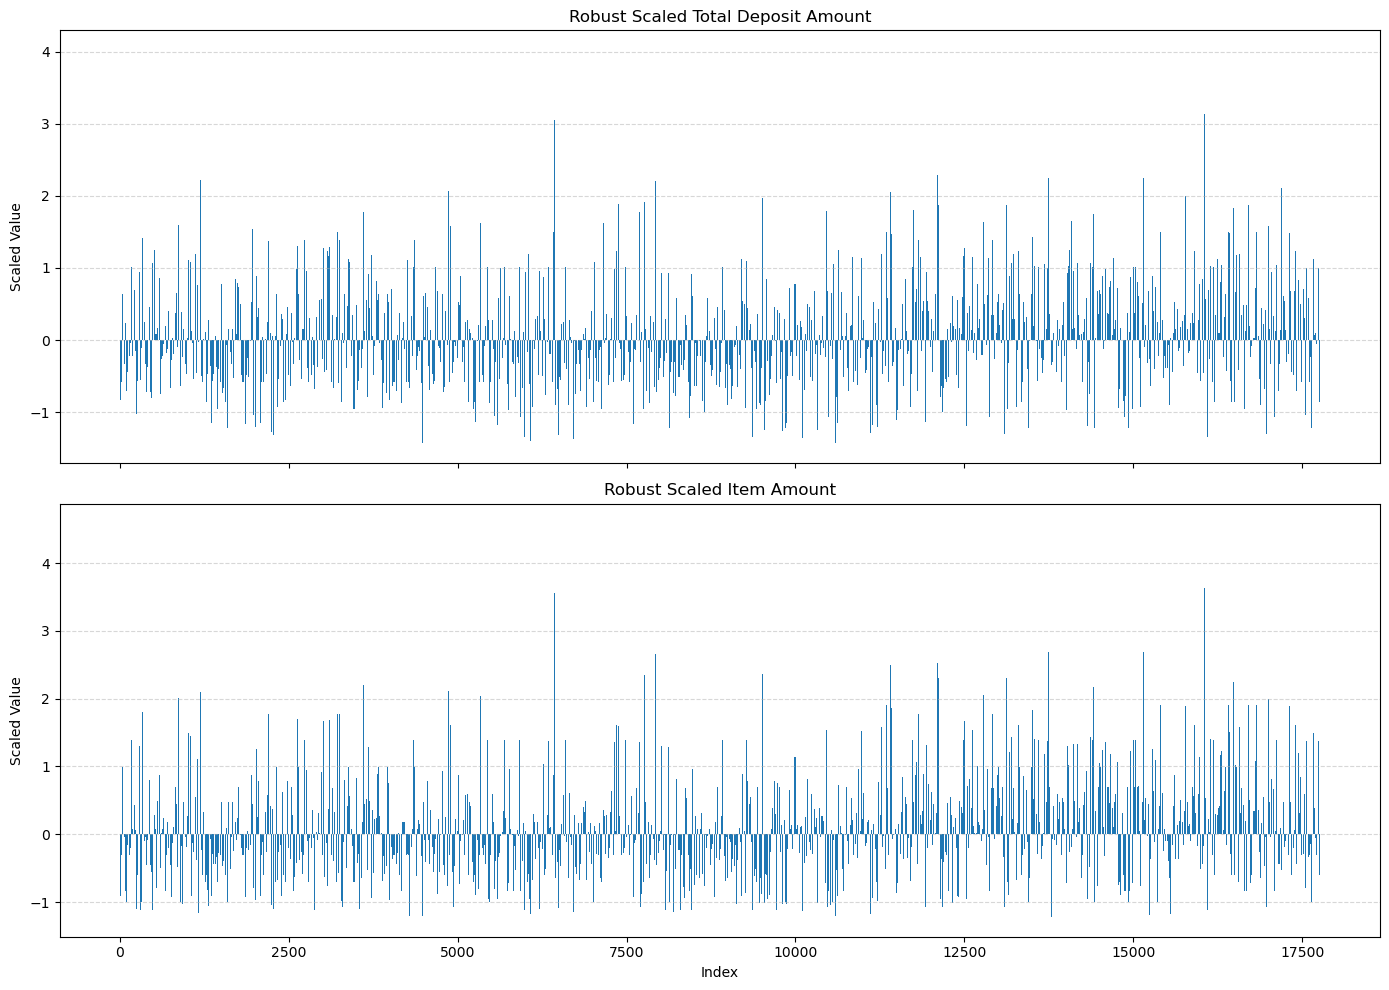

In [10]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# total_deposit_amount
axes[0].bar(df_final.index, df_final['robust_scaler__total_deposit_amount'])
axes[0].set_title('Robust Scaled Total Deposit Amount')
axes[0].set_ylabel('Scaled Value')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# item_amt
axes[1].bar(df_final.index, df_final['robust_scaler__item_amt'])
axes[1].set_title('Robust Scaled Item Amount')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Scaled Value')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [11]:
df['deposit_dt'] = pd.to_datetime(df['deposit_dt'])
df['deposit_dayofweek'] = df['deposit_dt'].dt.dayofweek
print(df['deposit_dayofweek'].value_counts().sort_index())


deposit_dayofweek
0    4907
1    3367
2    2801
3    2692
4    3998
Name: count, dtype: int64


In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17765 entries, 0 to 17764
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   cat__onus_ind_F                            17765 non-null  float64
 1   cat__onus_ind_T                            17765 non-null  float64
 2   cat__treasury_check_ind_N                  17765 non-null  float64
 3   cat__treasury_check_ind_Y                  17765 non-null  float64
 4   cat__heloc_ind_N                           17765 non-null  float64
 5   cat__heloc_ind_Y                           17765 non-null  float64
 6   cat__masked_bank_num_0                     17765 non-null  float64
 7   cat__masked_bank_num_1                     17765 non-null  float64
 8   cat__masked_bank_num_2                     17765 non-null  float64
 9   cat__masked_bank_num_3                     17765 non-null  float64
 10  cat__masked_bank_num_4